### Import package

In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

np.random.seed(2)
tf.set_random_seed(2)

%matplotlib inline

### Hyperparameter

In [2]:
MAX_EPISODES = 200
MAX_EP_STEPS = 200
LR_A = 0.001 # learning rate for actor
LR_C = 0.001 # learning rate for critic
DISPLAY_REWARD_THRESHOLD = -50
RENDER = False
GAMMA = 0.9 # reward discount factor
TAU = 0.01 # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

<img src='img/ddpg_pseudo.jpg'>

### DDPG

以下程式碼我們做了挖空的處理，註解有 `###` 的部分就要請你練習寫出來的地方

In [3]:
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound, sess):
        ### 請決定 memory 的維度
        self.memory = np.zeros((MEMORY_CAPACITY, ), dtype=np.float32) # state, next_state, action, reward
        self.pointer = 0
        self.sess = sess

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 'state_input')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 'next_state_input')
        self.R = tf.placeholder(tf.float32, [None, 1], 'reward')

        with tf.variable_scope('Actor'):
            self.action = self.create_actor(self.S, scope='eval', trainable=True)
            action_ = self.create_actor(self.S_, scope='target', trainable=False)
            
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            v = self.create_critic(self.S, self.action, scope='eval', trainable=True)
            v_ = self.create_critic(self.S_, action_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [[tf.assign(ta, (1 - TAU) * ta + TAU * ea), tf.assign(tc, (1 - TAU) * tc + TAU * ec)]
                             for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]
        
        ### 請寫出如何更新 critic, hint: use var_list when minimize the loss
        v_target = 
        
        # in the feed dict for the td_error, the self.action should change to actions in memory
        td_error = 
        self.critic_train = 
        
        ### 請寫出如何更新 actor
        exp_v =    # maximize the q
        self.actor_train = 

        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.action, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.actor_train, {self.S: bs})
        self.sess.run(self.critic_train, {self.S: bs, self.action: ba, self.R: br, self.S_: bs_})

        # soft target replacement
        self.sess.run(self.soft_replace)

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def create_actor(self, s, scope, trainable):
        ### 請練習定義 actor 的網路架構
        with tf.variable_scope(scope):
            
            
            return tf.multiply(a, self.a_bound, name='policy_action')

    def create_critic(self, s, a, scope, trainable):
        ### 請練習定義 critic 的網路架構
        with tf.variable_scope(scope):
            
            
            return   # Q(s,a)

### Environment Settings

In [4]:
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
env.seed(1)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
a_bound = env.action_space.high

### Initial DDPG

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
ddpg = DDPG(a_dim, s_dim, a_bound, sess=sess)

### Main training

In [5]:
var = 3  # control exploration
reward_history = []
for i in range(MAX_EPISODES):
    s = env.reset()
    t = 0
    ep_rs = 0
    while True:
        if RENDER:
            env.render()

        # Add exploration noise
        a = ddpg.choose_action(s)
        a = np.clip(np.random.normal(a, var), -2, 2)    # add randomness to action selection for exploration
        s_, r, done, info = env.step(a)
        r = r/10

        ddpg.store_transition(s, a, r, s_)
        
        # MEMORY 足夠大了就開始 learn
        if ddpg.pointer > MEMORY_CAPACITY:
            var *= .9995    # decay the action randomness
            ddpg.learn()

        s = s_
        t += 1
        ep_rs += r
        if t > MAX_EP_STEPS:
            reward_history.append(ep_rs)
            if 'running_reward' not in globals():
                running_reward = ep_rs
            else:
                running_reward = running_reward * 0.9 + ep_rs * 0.1 # 希望是穩定的 reward
            print('Episode:', i, ' Reward: %i' % int(running_reward), 'Explore: %.2f' % var, )
            if running_reward > DISPLAY_REWARD_THRESHOLD:RENDER = True
            break

Episode: 0  Reward: -167 Explore: 3.00
Episode: 1  Reward: -166 Explore: 3.00
Episode: 2  Reward: -166 Explore: 3.00
Episode: 3  Reward: -168 Explore: 3.00
Episode: 4  Reward: -167 Explore: 3.00
Episode: 5  Reward: -168 Explore: 3.00
Episode: 6  Reward: -168 Explore: 3.00
Episode: 7  Reward: -169 Explore: 3.00
Episode: 8  Reward: -167 Explore: 3.00
Episode: 9  Reward: -168 Explore: 3.00
Episode: 10  Reward: -167 Explore: 3.00
Episode: 11  Reward: -166 Explore: 3.00
Episode: 12  Reward: -167 Explore: 3.00
Episode: 13  Reward: -167 Explore: 3.00
Episode: 14  Reward: -167 Explore: 3.00
Episode: 15  Reward: -168 Explore: 3.00
Episode: 16  Reward: -167 Explore: 3.00
Episode: 17  Reward: -164 Explore: 3.00
Episode: 18  Reward: -162 Explore: 3.00
Episode: 19  Reward: -164 Explore: 3.00
Episode: 20  Reward: -165 Explore: 3.00
Episode: 21  Reward: -164 Explore: 3.00
Episode: 22  Reward: -160 Explore: 3.00
Episode: 23  Reward: -161 Explore: 3.00
Episode: 24  Reward: -161 Explore: 3.00
Episode: 2

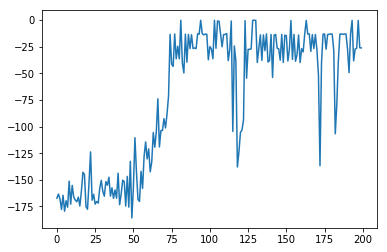

In [7]:
plt.plot(reward_history)

### Use checkpoint
這裡同樣有幫大家跑好的 model，有興趣的話可以 restore ddpg_v1.ckpt 這個 checkpoint 來玩 pendulum，看看 train 好的 agent 多強。

In [8]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
# Save the variables to disk.
save_path = saver.save(sess, "checkpoint/ddpg_v1.ckpt")

In [10]:
saver.restore(sess, "checkpoint/ddpg_v1.ckpt")
s = env.reset()
i_step = 0
while True:
    env.render()
    a = ddpg.choose_action(s)
    s_, r, done, info = env.step(a)
    s = s_
    i_step += 1
    if i_step > 300:
        break

INFO:tensorflow:Restoring parameters from checkpoint/ddpg_v1.ckpt
